In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.signal import butter,filtfilt,medfilt
from sklearn.decomposition import PCA
from pathlib import Path
%matplotlib inline


In [3]:
path = Path("C:\\Users\\Vishal\\Documents\\Uni\\CSI\\Dataset\\Data\\input_161219_siamak_bed_10.csv")

df = pd.read_csv(path, header= None).values

amp=df[:,1:91]
time = df[:,0]

print(amp)

[[14.618  19.818  20.391  ... 17.38   19.501  19.73  ]
 [15.204  20.989  20.899  ... 18.297  20.192  21.097 ]
 [15.079  19.66   20.902  ... 16.995  20.599  20.195 ]
 ...
 [ 5.8153  3.5108  3.5108 ... 17.661  17.808  16.183 ]
 [ 5.8238  3.5193  4.6587 ... 18.128  16.53   15.824 ]
 [ 3.1147  4.7118  3.5723 ... 17.95   17.016  15.721 ]]


In [4]:
def noise(amp):
    plt.figure(figsize=(12,5))
    for i in range (1,20):
        plt.plot(amp[:,i])
    plt.title("CSI with Noise")
    plt.show()

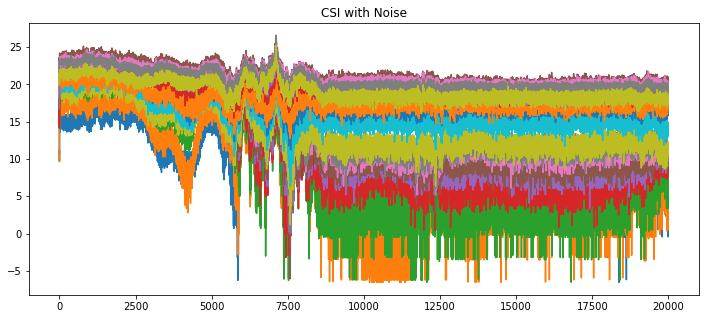

In [5]:
noise(amp)

In [6]:
# Filter requirements.
T = 20.0         # Sample Period
fs = 1000       # sample rate, Hz # 19997/20=999.85~1000
cutoff = 30      # desired cutoff frequency of the filter, Hz 
nyq = 0.5 * fs  # Nyquist Frequency
order = 5      # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples
#lowcut=30
#highcut=80

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [7]:
amp_filter = np.empty_like(amp)
for i in range(0,90):
    amp_filter[:,i] = butter_lowpass_filter(amp[:,i], cutoff, fs, order)

print(amp_filter.shape)


(19989, 90)


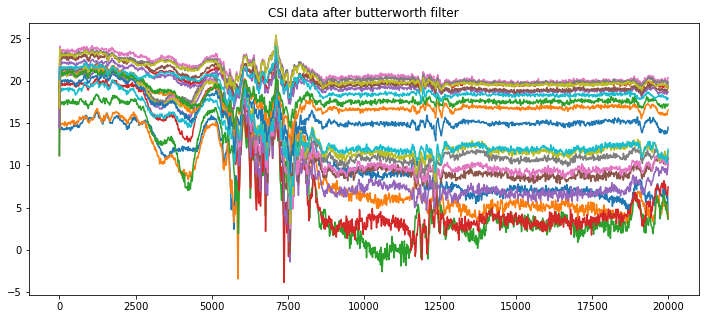

In [8]:
plt.figure(figsize=(12,5))
for i in range(0,20):
    plt.plot(amp_filter[:,i])    
plt.title("CSI data after butterworth filter")
plt.show()

In [9]:
amp_pca = PCA(n_components=90)
amp_pca.fit(amp_filter.T)
amp_final_pca = amp_pca.components_.T

print(amp_pca.explained_variance_)
print(amp_final_pca.shape)

[1.12467188e+06 3.63440457e+04 6.22059957e+03 3.09507563e+03
 2.69831274e+03 1.28395021e+03 9.62057341e+02 8.31645442e+02
 7.13023085e+02 5.72800963e+02 3.00343584e+02 2.68632971e+02
 1.99585352e+02 1.84905435e+02 1.48814722e+02 1.08579290e+02
 9.75926216e+01 9.21862043e+01 7.71857387e+01 7.18367952e+01
 6.69168170e+01 6.19270033e+01 5.84987879e+01 5.13398013e+01
 4.80882903e+01 4.72144094e+01 4.07131686e+01 3.80019765e+01
 3.32195049e+01 3.24623709e+01 3.04750765e+01 2.80230760e+01
 2.58627108e+01 2.40100838e+01 2.07047769e+01 1.96058394e+01
 1.82963048e+01 1.77732155e+01 1.67006419e+01 1.46150970e+01
 1.38226560e+01 1.10661065e+01 1.03384292e+01 9.41161918e+00
 9.10227926e+00 8.83405512e+00 7.99441807e+00 6.34487204e+00
 6.28430600e+00 5.54732606e+00 5.40983896e+00 5.00779286e+00
 4.71588884e+00 4.19618168e+00 3.60121652e+00 3.39608848e+00
 2.93134631e+00 2.67886435e+00 2.21155977e+00 2.03651287e+00
 1.75887062e+00 1.68755283e+00 1.65331151e+00 1.48350967e+00
 1.33794782e+00 1.278108

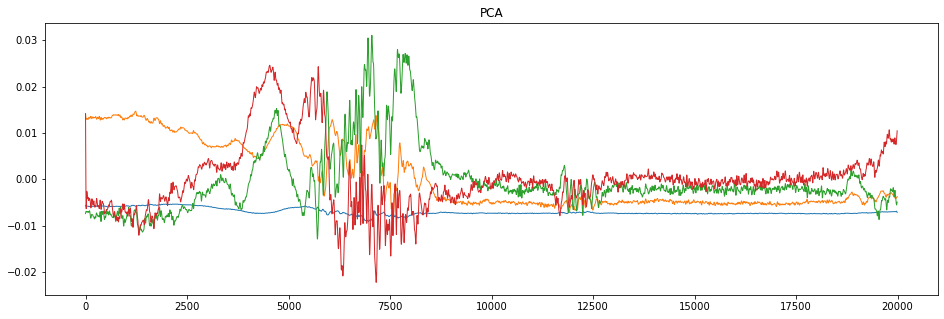

In [11]:
plt.figure(figsize=(16,5))
for i in 0,1,2,3:
    plt.plot(amp_final_pca[:,i],linewidth=1)
plt.title("PCA")
plt.show()

In [8]:
amp_final = np.empty_like(amp_final_pca)
for i in range (0,90):
    amp_final[:,i] = medfilt(amp_final_pca[:,i],91)

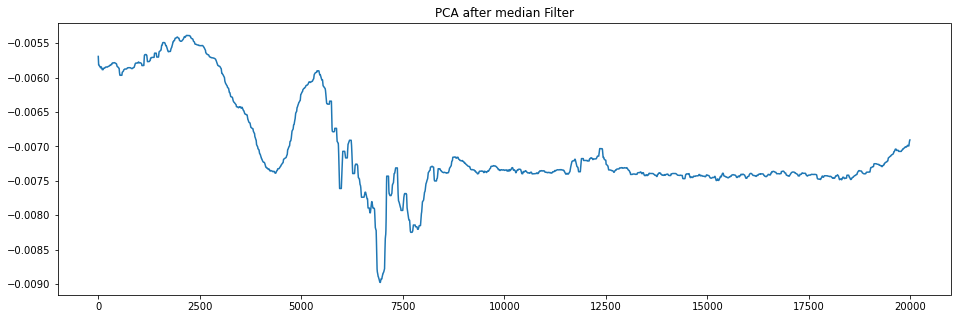

In [18]:
plt.figure(figsize=(16,5))
plt.plot(amp_final[:,0])
plt.title("PCA after median Filter")
plt.show()

In [9]:
amp_final.shape

(19989, 90)

In [10]:
#Since Sameple Rate = 999.85 ~ 1000 so we take Window Size = 1001
window_size = 1001
slide_size = 200
threshold = 60

path = Path("C:\\Users\\Vishal\\Documents\\Uni\\CSI\\Dataset\Data\\annotation_siamak_bed_10.csv")
df = pd.read_csv(path,header= None)
print(df)
annotations = df

                0
0      NoActivity
1      NoActivity
2      NoActivity
3      NoActivity
4      NoActivity
...           ...
19984  NoActivity
19985  NoActivity
19986  NoActivity
19987  NoActivity
19988  NoActivity

[19989 rows x 1 columns]


In [11]:
def windowing(amp_final,annotations):
    xx = np.empty([0,window_size,90],float)
    yy = np.empty([0,8],float)

    tmp1 = amp_final
    x2 = np.empty([0,window_size,90],float)

    k = 0
    while(k <= (len(tmp1) + 1 - 2 * window_size)):
        x = np.dstack(np.array(tmp1[k:k + window_size, 0:90]).T)
        x2 = np.concatenate((x2,x), axis=0)
        k += slide_size
    
    xx = np.concatenate((xx,x2), axis=0)
    xx = xx.reshape(len(xx), -1)

    tmp2 = annotations
    y = np.zeros(((len(tmp2) + 1 - 2 * window_size) // slide_size + 1, 8))
    k=0
    while( k <= (len(tmp2) + 1 - 2 * window_size)):
        y_pre = np.stack(np.array(tmp2[k:k + window_size]))
        bed = 0
        fall = 0
        walk = 0
        pickup = 0
        run = 0
        sitdown = 0
        standup = 0
        noactivity = 0
        
        for j in range(window_size):
            if y_pre[j] == "bed":
                bed += 1
            elif y_pre[j] == "fall":
                fall += 1
            elif y_pre[j] == "walk":
                walk += 1
            elif y_pre[j] == "pickup":
                pickup += 1
            elif y_pre[j] == "run":
                run += 1
            elif y_pre[j] == "sitdown":
                sitdown += 1
            elif y_pre[j] == "standup":
                standup += 1
            else:
                noactivity += 1
        
        if bed > window_size * threshold / 100:
            y[k // slide_size, :] = np.array([0, 1, 0, 0, 0, 0, 0, 0])
        elif fall > window_size * threshold / 100:
            y[k // slide_size, :] = np.array([0, 0, 1, 0, 0, 0, 0, 0])
        elif walk > window_size * threshold / 100:
            y[k // slide_size, :] = np.array([0, 0, 0, 1, 0, 0, 0, 0])
        elif pickup > window_size * threshold / 100:
            y[k // slide_size, :] = np.array([0, 0, 0, 0, 1, 0, 0, 0])
        elif run > window_size * threshold / 100:
            y[k // slide_size, :] = np.array([0, 0, 0, 0, 0, 1, 0, 0])
        elif sitdown > window_size * threshold / 100:
            y[k // slide_size, :] = np.array([0, 0, 0, 0, 0, 0, 1, 0])
        elif standup > window_size * threshold / 100:
            y[k // slide_size, :] = np.array([0, 0, 0, 0, 0, 0, 0, 1])
        else:
            y[k // slide_size, :] = np.array([2, 0, 0, 0, 0, 0, 0, 0])
        k += slide_size

    yy = np.concatenate((yy, y), axis=0)

    return xx,yy

In [12]:
windowed_amp,windowed_anno = windowing(amp_final,annotations)

In [13]:
print(windowed_amp.shape)
print(windowed_anno.shape)

(90, 90090)
(90, 8)
